In [2]:
import network_module_E91
from scipy.optimize import minimize
import numpy as np

In [3]:
theta1 = 0.7854          
theta2 = 0          
theta3 = -0.3927        
theta4 = 0.3927
fidelity = 0.80
precision = 2500
distance = 20
attenuation = .0002
num_exp = 10

In [4]:
import numpy as np

def wrap_angles(x):
    """Map angles to (-pi, pi], vectorized."""
    y = (x + np.pi) % (2*np.pi) - np.pi        # gives (-pi, pi]
    # ensure -pi maps to +pi to avoid duplicate endpoints
    y = np.where(np.isclose(y, -np.pi), np.pi, y)
    return y

In [5]:
import numpy as np
import time
from scipy.optimize import minimize

TWO_PI = 2*np.pi


def Nelder_Mead(deltas, time_limit=400, precision=2500, simplex_step=0.8, seed=None,distance=10e1,attenuation=attenuation):
    rng = np.random.default_rng(seed)

    start_time = time.time()
    winrate_best = -np.inf
    S_best = -np.inf
    S_curve = []
    time_curve = []
    best_angles = None
    last_x_eval = None  # fallback if timeout happens before improvement

    # def wrap_angles(a):
    #     # map R -> (-pi, pi]
    #     return (a + np.pi) % TWO_PI - np.pi

    PI = np.pi
    TWO_PI = 2 * np.pi

    def wrap_to_pi_half(a):
    # First wrap to [0, 2π)
        a = a % TWO_PI
    # Then fold [π, 2π) back into [0, π]
        if isinstance(a, np.ndarray):
            return np.where(a > PI, TWO_PI - a, a)
        else:
            return TWO_PI - a if a > PI else a

    def make_initial_simplex(center, step=simplex_step):
        # Build a "fat" simplex around the center
        center = center.copy()
        simplex = [center]
        n = center.size
        for i in range(n):
            v = center.copy()
            v[i] = v[i] + step   # do NOT wrap optimizer variables here
            simplex.append(v)
        return np.array(simplex)

    def objective(x):
        nonlocal S_best, best_angles, winrate_best, last_x_eval
        last_x_eval = x.copy()

        # Enforce time budget
        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        # Only wrap when passing to the simulator
        x_wrapped = wrap_angles(np.asarray(x, dtype=float))
        alphas_alice = x_wrapped[0:3]
        alphas_bob = [0,0,0]

        game = network_module_E91.Game(deltas=deltas, fid=fidelity,distance=distance,attenuation=attenuation)
        # winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        # S = g.referee.compute_chsh_s()
        # print("Alphas alice:", alphas_alice)
        key_a, key_b, S, chsh_data = game.run_e91(
            num_rounds=precision,
            alphas_alice=alphas_alice ,
            alphas_bob=[0,0,0],
            verbose=False
        )

        # print("Alphas (wrapped):", x_wrapped, " winrate:", winrate, " S:", S)

        # Track best by winrate (objective); keep S_best and angles alongside
        # print(winrate,S)
        if S > S_best:
            # winrate_best = winrate
            S_best = S
            best_angles = x_wrapped.copy()

        # Convergence traces (best-so-far S vs time)
        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -S # NM minimizes

    # ----- Initialization -----
    # Random center in (-pi, pi]; keeps things from getting stuck at trivial zero
    # x0 = rng.uniform(-np.pi, np.pi, size=3)
    x0 = np.array([np.pi/2,np.pi/2,np.pi/2])
    init_simplex = make_initial_simplex(x0, step=simplex_step)

    try:
        res = minimize(
            objective,
            x0,
            method='Nelder-Mead',
            options={
                'initial_simplex': init_simplex,
                'adaptive': True,
                'maxiter': 10000,
                'maxfev': 20000,
                'xatol': 1e-3,
                'fatol': 1e-3,
                'disp': True,
            },
        )
    except TimeoutError:
        res = None  # we’ll return best-so-far

    total_time = time.time() - start_time

    # Fallbacks if nothing improved before timeout
    if best_angles is None:
        # If we never improved, return the last evaluated wrapped point
        best_angles = wrap_angles(last_x_eval) if last_x_eval is not None else wrap_angles(x0)

    return best_angles, total_time, S_curve, time_curve

In [6]:
def COBYQA_OPT_TIME(deltas, time_limit=400, precision=2500,attenuation=0,distance=10e1):
    start_time = time.time()
    winrate_best_C = -np.inf
    S_best_C = 0
    S_curve = []
    time_curve = []
    best_angles_C = []
    
    def objective(x):
        nonlocal S_best_C,best_angles_C,winrate_best_C
        # print("Alphas:",x)
        # nonlocal S_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")
        x_wrapped = wrap_angles(np.asarray(x, dtype=float))
        alphas_alice = x[0:3]
        # alphas_bob = x[3:]
        alphas_bob = [0,0,0]

        game = network_module_E91.Game(deltas=deltas, fid=fidelity,distance=distance,attenuation=attenuation)
        # winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        # S = g.referee.compute_chsh_s()
        # print("Alphas alice:", alphas_alice)
        key_a, key_b, S, chsh_data = game.run_e91(
            num_rounds=precision,
            alphas_alice=alphas_alice ,
            alphas_bob=[0,0,0],
            verbose=False
        )
        if S > S_best_C:
            # winrate_best = winrate
            S_best_C = S
            best_angles_C = x_wrapped.copy()

        S_curve.append(S_best_C)
        time_curve.append(elapsed)

        return -S   # Minimization

    # x0 = np.random.uniform(-np.pi, np.pi, 6)
    x0 = np.array([np.pi/2,np.pi/2,np.pi/2])
    pi_val = np.pi
    cons = []
    for i in range(3):
    # x[i] >= -pi  ->  x[i] + pi >= 0
        # cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] + pi_val})
    # x[i] <= pi   ->  pi - x[i] >= 0
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: pi_val - x[i]})

    try:
        # res = minimize(objective, x0, method='COBYLA', constraints=cons,options={'maxiter': 10000})
        res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})
    except TimeoutError:
        pass
    total_time = time.time() - start_time
    return best_angles_C, total_time, S_curve, time_curve

In [7]:
import time


# Convergence progress
BO_conv = []
NM_conv = []
COB_conv = []

# Time curves (per iteration)
BO_time_curve = []
NM_time_curve = []
COB_time_curve = []

# Validation results
BO_res = []
NM_res = []
COB_res = []

# Total optimization time
BO_time = []
NM_time = []
COB_time = []

for x in range(num_exp):
    print("Iteration:", x)
    deltaA = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltaB = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltas = [deltaA, deltaB]

    # ----- Bayesian Optimization -----
    # start_time = time.time()
    # X_high_fid, total_time, progress, time_curve = BayesOPT(deltas, time_limit=400, precision=2500)
    # end_time = time.time()
    
    # BO_conv.append(progress)
    # BO_time_curve.append(time_curve)
    # BO_time.append(end_time - start_time)

    # alphas_alice = X_high_fid[0:3]
    # # alphas_bob = X_high_fid[3:6]
    # alphas_bob = [0,0,0]
    # g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=fidelity)
    # g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    # S_high = g.referee.compute_chsh_s()
    # print("Validation:", S_high)
    # BO_res.append(S_high)

    # ----- Nelder-Mead -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = Nelder_Mead(deltas, time_limit=400, precision=2500,
                                                               distance=distance,attenuation=attenuation)
    end_time = time.time()

    NM_conv.append(progress)
    NM_time_curve.append(time_curve)
    NM_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    # alphas_bob = X_high_fid[3:6]
    alphas_bob = [0,0,0]
    game = network_module_E91.Game(deltas=deltas, guarantee_entanglement=True, fid=fidelity,distance=distance,attenuation=attenuation)
    key_a, key_b, S_high, chsh_data = game.run_e91(
            num_rounds=precision,
            alphas_alice=alphas_alice ,
            alphas_bob=[0,0,0],
            verbose=False
        )
    print("VALIDATION:",S_high)
    NM_res.append(S_high) 

    # ----- COBYQA -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = COBYQA_OPT_TIME(deltas, time_limit=400, precision=2500,distance=distance,attenuation=attenuation)
    end_time = time.time()

    COB_conv.append(progress)
    COB_time_curve.append(time_curve)
    COB_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    print(alphas_alice)
    # alphas_bob = X_high_fid[3:]
    alphas_bob = [0,0,0]
    game = network_module_E91.Game(deltas=deltas, guarantee_entanglement=True, fid=fidelity,distance=distance,attenuation=attenuation)
    key_a, key_b, S_high, chsh_data = game.run_e91(
            num_rounds=precision,
            alphas_alice=alphas_alice ,
            alphas_bob=[0,0,0],
            verbose=False
        )
    print("VALIDATION:",S_high)
    COB_res.append(S_high)


Iteration: 0
VALIDATION: 2.1602954889664927


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[1.81445667 0.44463583 1.6335415 ]
VALIDATION: 1.4495957849748375
Iteration: 1
VALIDATION: 2.037787920469878


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[1.53110673 1.60095945 1.6009245 ]
VALIDATION: 1.8988810984247582
Iteration: 2
VALIDATION: 1.9248322741666226


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[1.60297385 1.53252674 2.57100885]
VALIDATION: 1.5619946650168093
Iteration: 3
VALIDATION: 2.191141420817561


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[2.57079633 1.57079633 1.57079633]
VALIDATION: 2.0392671127667215
Iteration: 4
VALIDATION: 2.2101539835213235


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[2.80753664 1.49591884 2.1015789 ]
VALIDATION: 1.638602158502287
Iteration: 5
VALIDATION: 1.8028606624369832


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[1.63728314 1.16180281 0.78851202]
VALIDATION: 1.892864965304745
Iteration: 6
VALIDATION: 2.0755973761551507


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[ 1.70306384 -0.22196997  1.88259399]
VALIDATION: 2.0787206127284428
Iteration: 7
VALIDATION: 2.1360401379929885


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[2.56831729 1.81641871 1.52399772]
VALIDATION: 1.8420313683171576
Iteration: 8
VALIDATION: 2.0152094877732676


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[2.48183508 1.64630903 1.27650838]
VALIDATION: 2.0148746874333616
Iteration: 9
VALIDATION: 1.9461022481500296


/tmp/ipykernel_6039/1310102078.py:54: OptimizeWarning: Unknown solver options: rhobeg
  res = minimize(objective, x0, method='COBYQA',options={'maxiter': 10000,'rhobeg':1.0})


[1.67868074 1.87703841 0.53785479]
VALIDATION: 1.829025801914859


In [8]:
import statistics

In [9]:
def pad_with_last_value(runs):
    max_len = max(len(run) for run in runs)
    padded = np.array([
        np.pad(run, (0, max_len - len(run)), mode='edge')
        for run in runs
    ])
    return padded


In [10]:
# BO_time_curve_padded = pad_with_last_value(BO_time_curve)
NM_time_curve_padded = pad_with_last_value(NM_time_curve)
COB_time_curve_padded = pad_with_last_value(COB_time_curve)

# BO_conv_padded = pad_with_last_value(BO_conv)
NM_conv_padded = pad_with_last_value(NM_conv)
COB_conv_padded = pad_with_last_value(COB_conv)

# Compute mean + std over runs
# BO_time_mean = BO_time_curve_padded.mean(axis=0)
# BO_mean = BO_conv_padded.mean(axis=0)
# BO_std  = BO_conv_padded.std(axis=0)

NM_time_mean = NM_time_curve_padded.mean(axis=0)
NM_mean = NM_conv_padded.mean(axis=0)
NM_std  = NM_conv_padded.std(axis=0)

COB_time_mean = COB_time_curve_padded.mean(axis=0)
COB_mean = COB_conv_padded.mean(axis=0)
COB_std  = COB_conv_padded.std(axis=0)

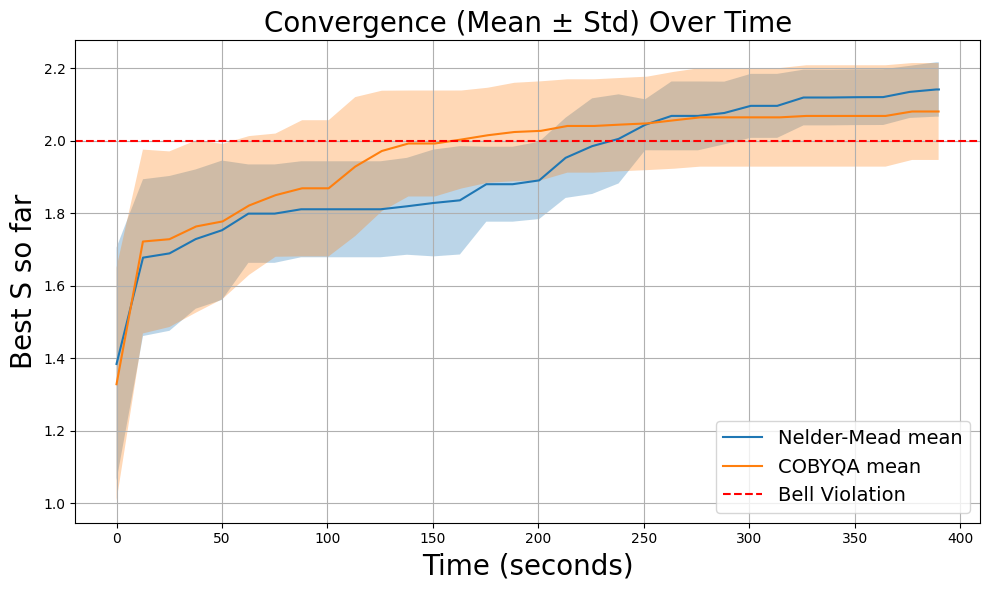

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# plt.plot(BO_time_mean, BO_mean, label='BO mean')
# plt.fill_between(BO_time_mean, BO_mean - BO_std, BO_mean + BO_std, alpha=0.3)

plt.plot(NM_time_mean, NM_mean, label='Nelder-Mead mean')
plt.fill_between(NM_time_mean, NM_mean - NM_std, NM_mean + NM_std, alpha=0.3)

plt.plot(COB_time_mean, COB_mean, label='COBYQA mean')
plt.fill_between(COB_time_mean, COB_mean - COB_std, COB_mean + COB_std, alpha=0.3)

# Add Bell violation line
plt.axhline(y=2, color='red', linestyle='--', label='Bell Violation')

plt.xlabel('Time (seconds)', fontsize=20)
plt.ylabel('Best S so far', fontsize=20)
plt.title('Convergence (Mean ± Std) Over Time', fontsize=20)

plt.legend(fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
